In [1]:
import numpy as np
from scipy.sparse import csr_matrix, diags, spdiags
from scipy.sparse.linalg import spsolve, eigs, eigsh
import matplotlib.pyplot as plt
import numba
from numba import jit, njit

## Method 1

In [2]:
Nx, Ny, Nt = 50, 50, 2000
xi, yi, xf, yf = 0.0, 0.0, 1.0, 1.0

In [3]:
nx, ny = Nx, Ny
def u0(x, y): 
    ans = 500*(x-x+1)
    #Dish
    ans[(x-0.5)**2+(y-0.5)**2 > 1/64]=300
    #Small disk
#     ans[(x-0.5)**2+(y-0.5)**2 > 1/16]=300
    #Big disk
#     ans[(x-0.5)**2+(y-0.5)**2 > 1/4]=300
    return ans

def alpha(x, y):
    a = np.zeros([nx, ny])
    #Dish
    a[(x-0.5)**2+(y-0.5)**2 < 1/64] = 1e-4
    #Small disk
#     a[(x-0.5)**2+(y-0.5)**2 < 1/16] = 1e-4
    #Big disk
#     a[(x-0.5)**2+(y-0.5)**2 < 1/4] = 1e-4

    return  a

x, y = np.linspace(xi, xf, nx), np.linspace(yi, yf, ny)
X, Y = np.meshgrid(x, y)
ALPHA = alpha(X, Y)
grid = u0(X, Y)
U0 = grid.copy()

In [4]:
dx2 = (yf-yi)*(xf - xi)/((Nx-1)*(Ny-1))
dt = dx2/(4.1*np.max(ALPHA))
# dt = 1
#If the result is bigger then 1/4, it diverges
np.max(ALPHA*dt/dx2)
dt

1.0158368972277811

In [5]:
array = np.zeros([Nt, Nx, Ny])
array[0] = grid

In [6]:
def loops():
    old = grid
    new = grid.copy()
    # alpha = a(x, y)
    for t in range(1, Nt):
        for i in range(1, Nx-1):
            for j in range(1, Ny - 1):
                whatever = old[i+1][j] + old[i - 1][j] + old[i][j+1] + old[i][j-1]
                whatever = whatever - 4*old[i][j]
                new[i][j] = old[i][j] + ALPHA[i][j]*dt/dx2 * whatever
        old = new.copy()
        array[t] = old.copy()
    return array
Sol = loops()

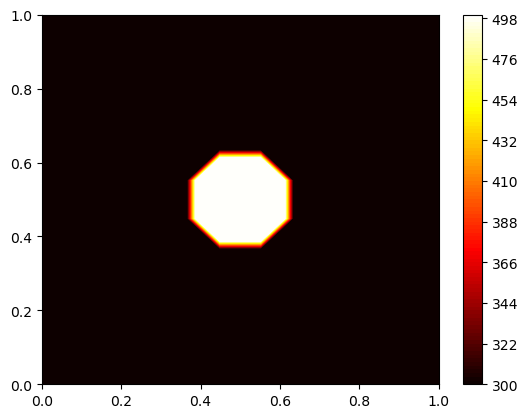

In [73]:
plt.contourf(x, y, Sol[0], levels = 100, cmap = "hot")
plt.colorbar()
plt.show()

### Newton's Law of cooling

In [7]:
averages = np.array([np.average(Sol[i][U0 != 300]) for i in range(Nt)])
maxes = np.array([np.max(Sol[i][U0 != 300]) for i in range(Nt)])

In [8]:
tplt = np.linspace(0, Nt*dt, Nt)

In [9]:
# best fit
b = np.log(200/(averages - 300))
T = np.arange(0, Nt*dt, dt)
k = np.dot(T, b)/np.dot(T, T)
k

0.023021934471741924

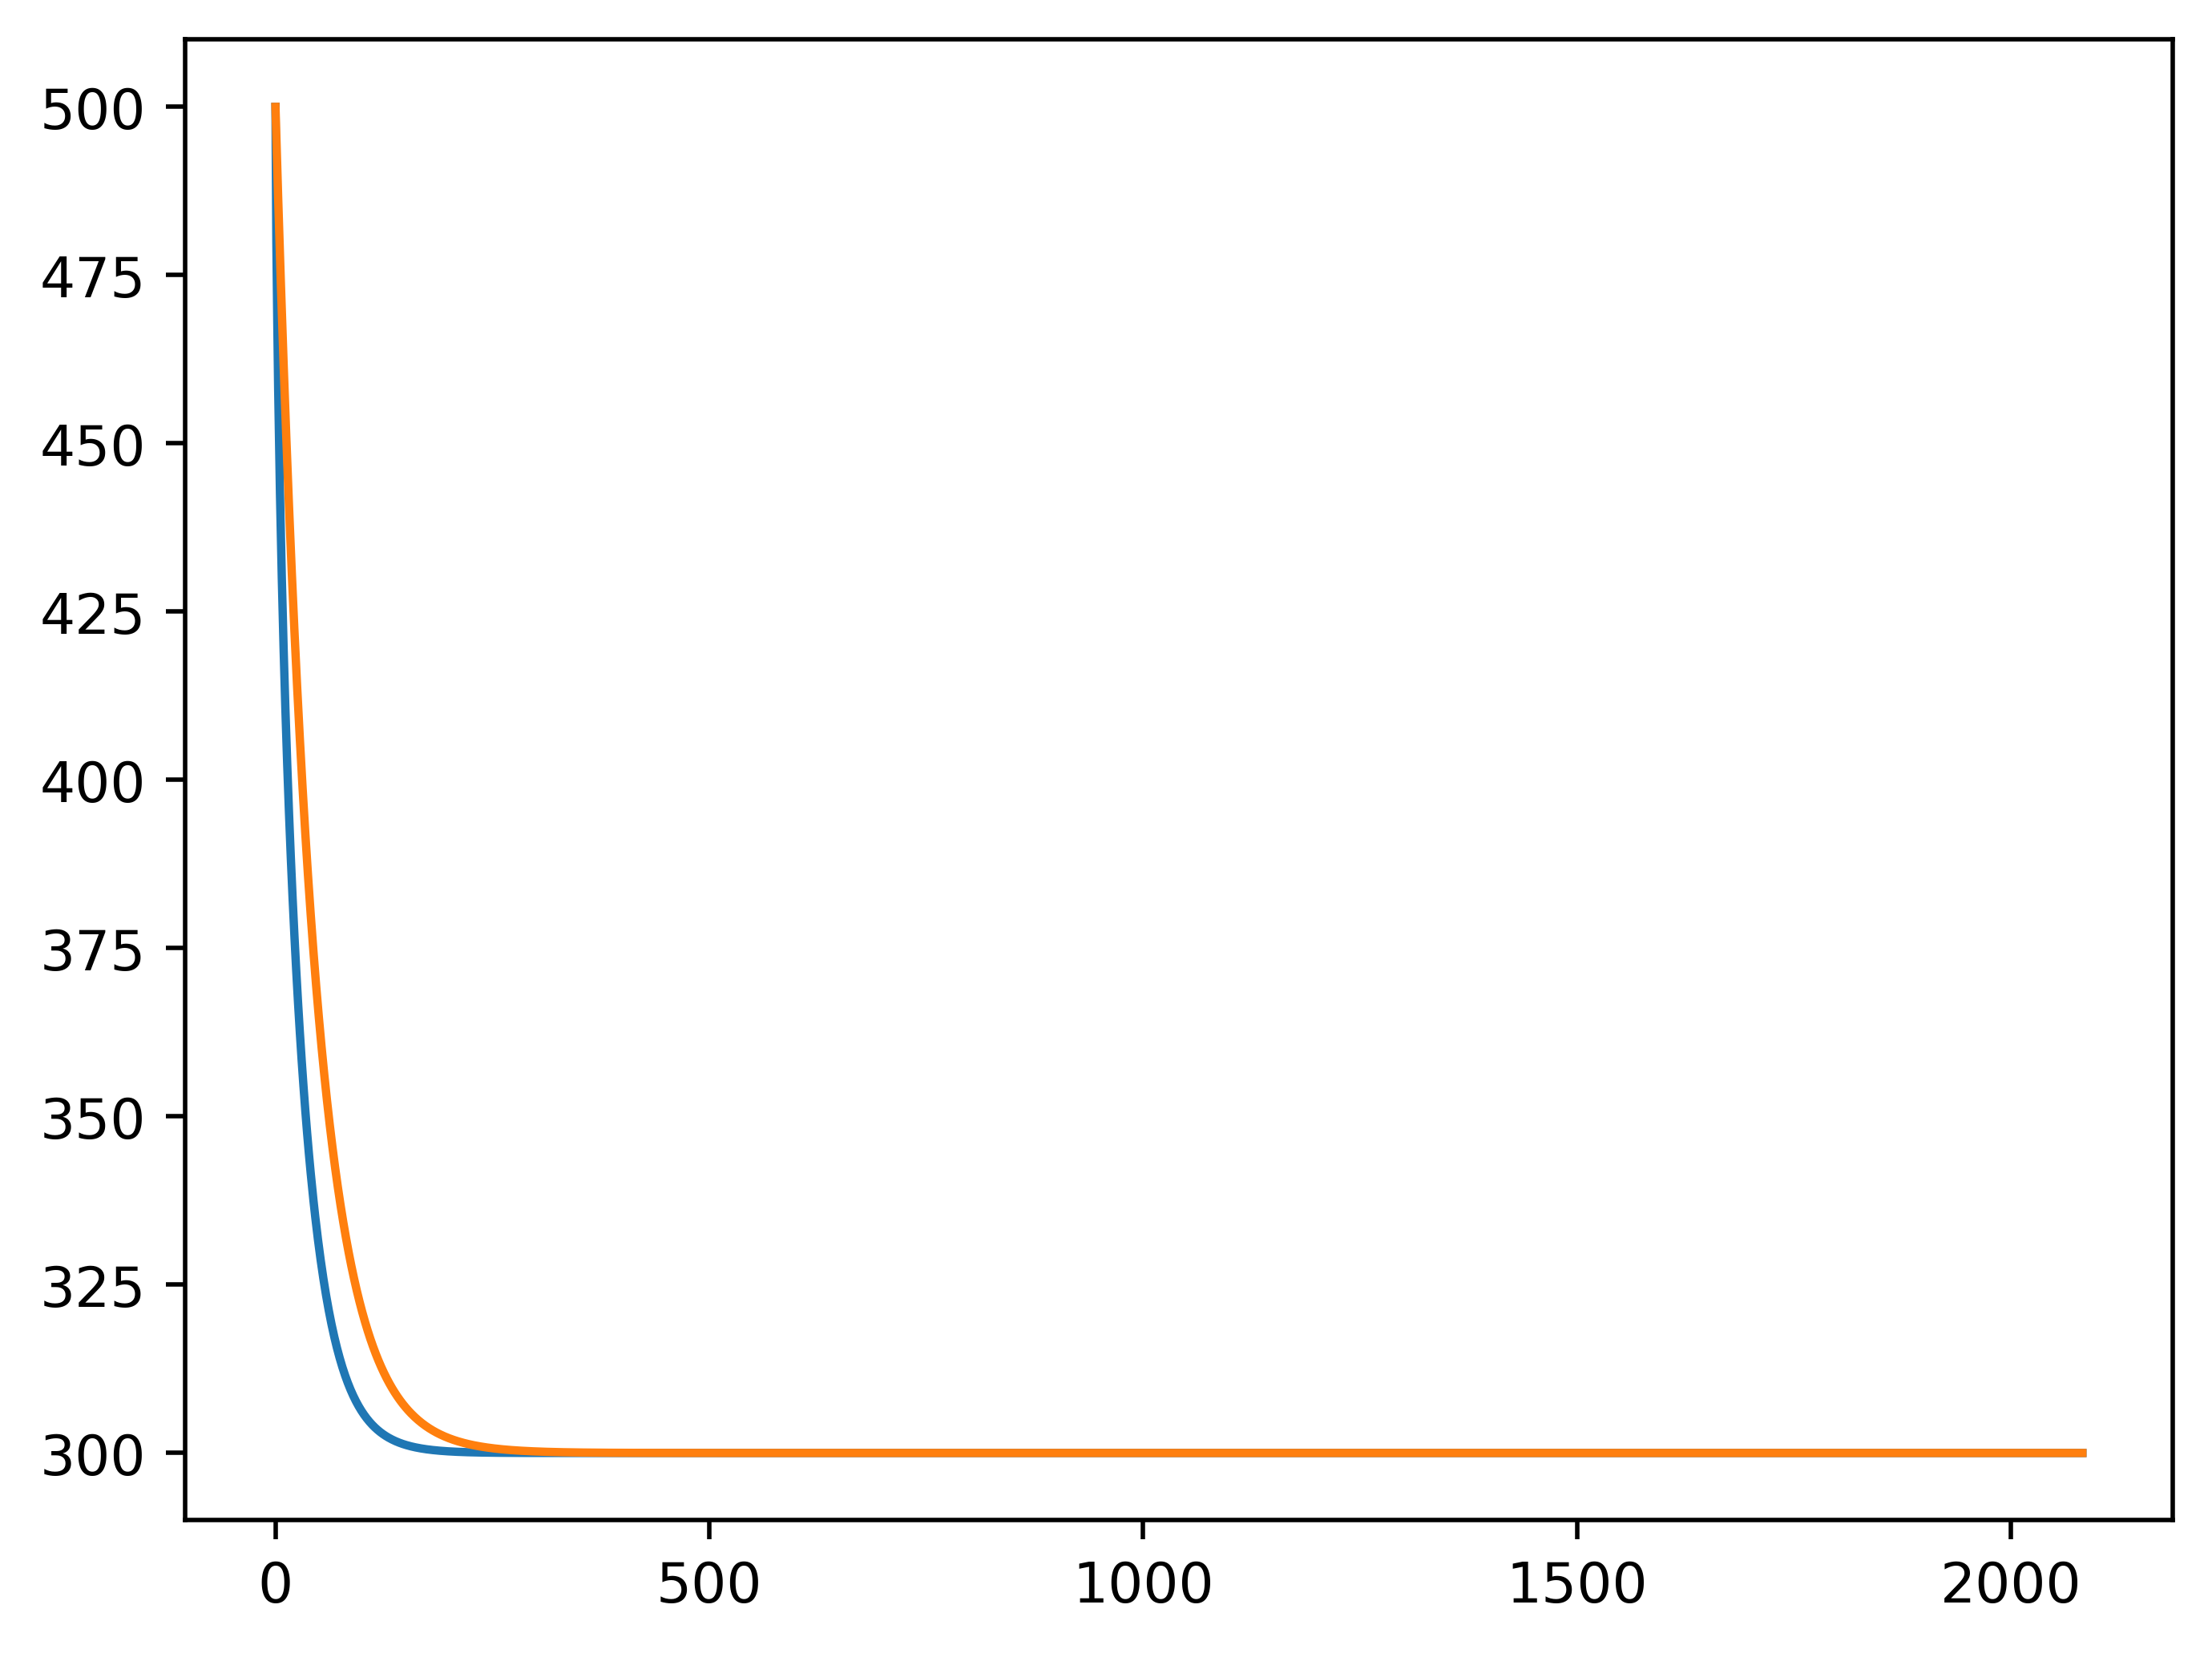

In [33]:
plt.figure(dpi = 500)
plt.plot(tplt, averages)
plt.plot(tplt, 300+200*np.exp(-k*tplt))
plt.savefig(".\\newton_cooling_dish.png", facecolor = 'w', dpi = 500, bbox_inches = "tight")
plt.show()

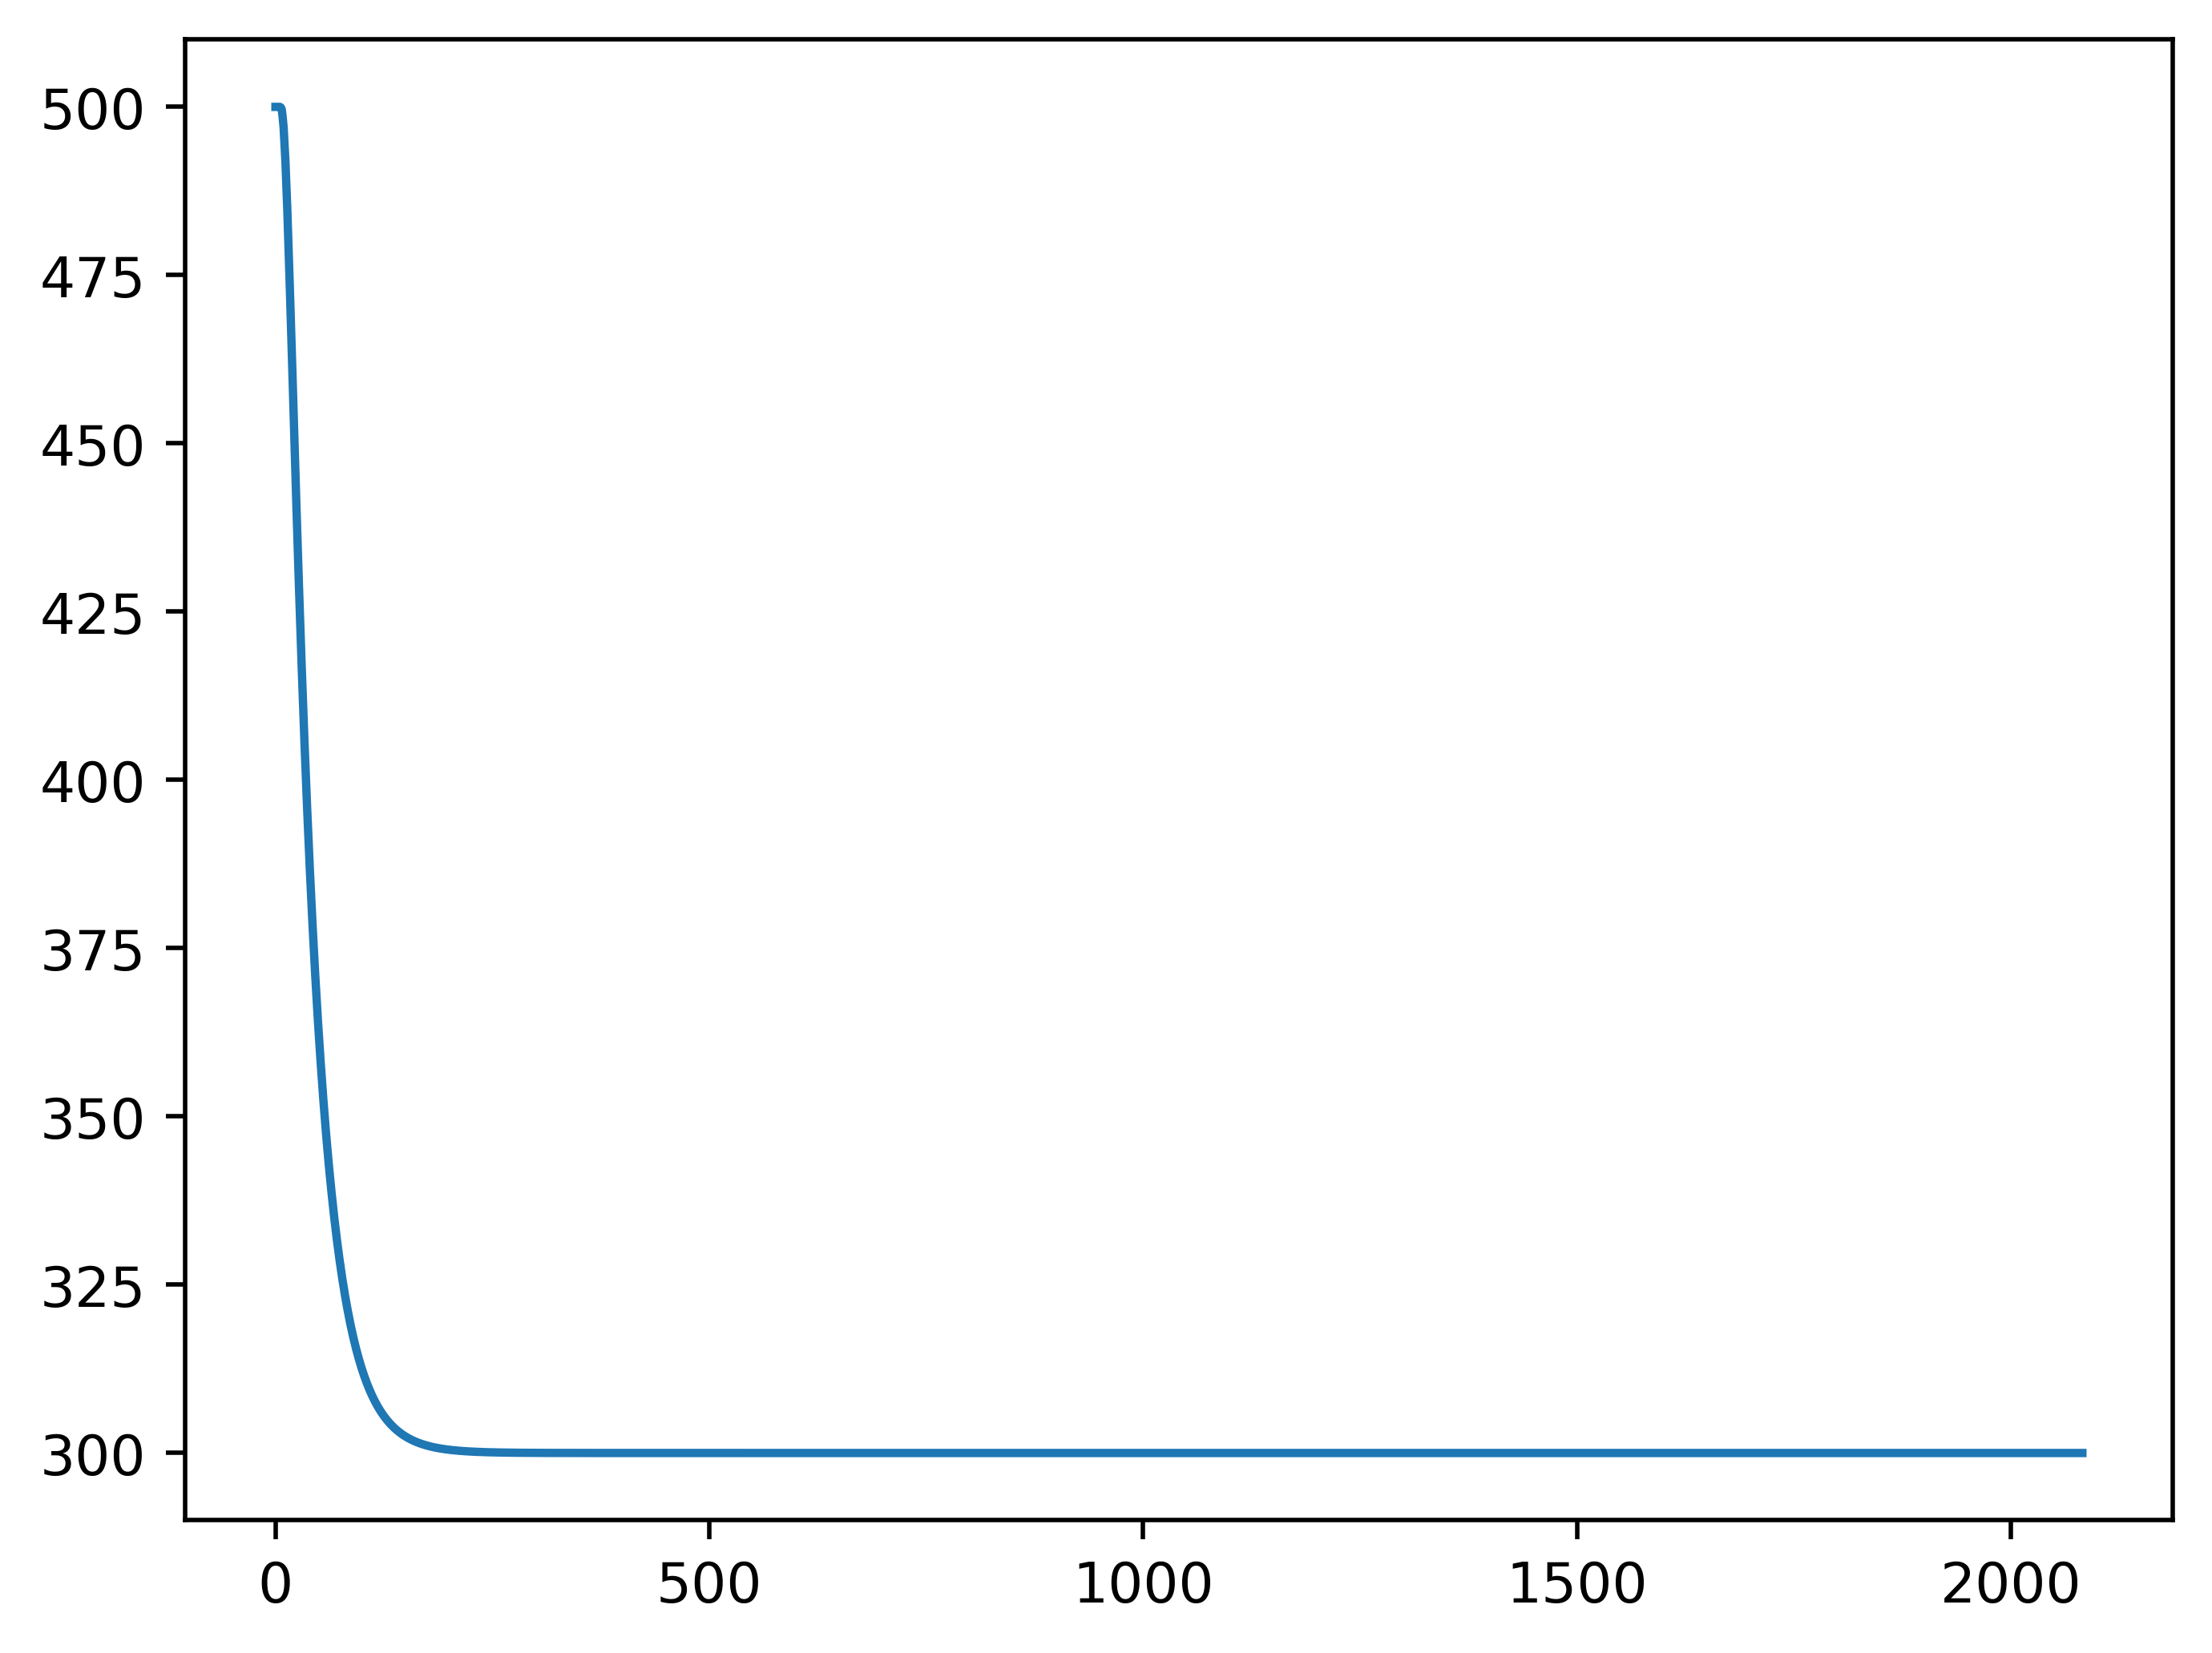

In [34]:
plt.figure(dpi = 500)
plt.plot(tplt, maxes)
plt.savefig(".\\maxtempdish.png", facecolor = 'w', dpi = 500, bbox_inches = "tight")
plt.show()

### Animation

In [38]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

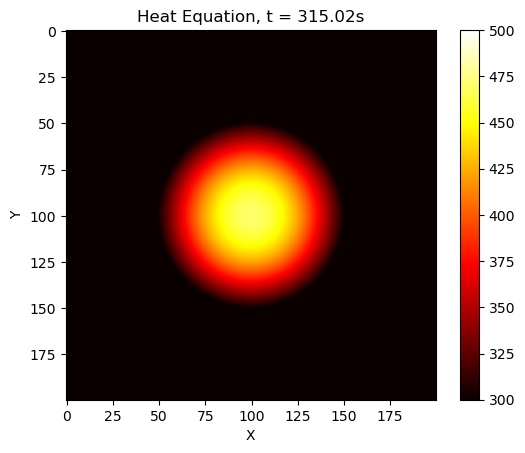

In [41]:
# Initialize the figure and axes
fig, ax = plt.subplots()
im = ax.imshow(Sol[0], cmap='hot', animated=True)
cbar = fig.colorbar(im)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Heat Equation')

# Define the update function for the animation
def update(n):
    im.set_data(Sol[2*n])
    ax.set_title(f"Heat Equation, t = {10*n*dt:.2f}s")
    return im

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=Nt//10, interval=50)
ani.save("pictures/smdsk_BA.gif",writer='pillow',fps=60)

## Method 2

In [2]:
def u0(x, y): 
    ans = 200*(x-x+1)
    ans[(x-0.5)**2+ (y-0.5)**2>0.25]=0
    return ans
nx, ny = 100, 100
alpha = lambda x, y: np.ones(len(x)*len(y))*1e-4
def pot(x, y):
    a = np.zeros([nx, ny])
    a[(x-0.5)**2+ (y-0.5)**2>0.25] = 1e6
    return  a
x, y = np.linspace(0, 1, nx), np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)
ALPHA = alpha(X, Y)
ALPHA=ALPHA.reshape(nx*ny)
U0 = u0(X, Y)
U0=U0.reshape(nx*ny)
POT = pot(X, Y).reshape(nx*ny)

In [3]:
N = nx*ny
dxdx = 1/N
main_diagonal = -(np.ones(N))*4/(dxdx)
# main_diagonal
sd_1 = np.ones(N)/dxdx
sd_1[np.arange(1, N+1, 1)%nx == 0] = 0
sd_2 = np.ones(N)/(dxdx)


In [4]:
diagonals = [main_diagonal, sd_1[:-1], sd_1[:-1], sd_2[nx:], sd_2[:-nx]]

laplacian = diags(diagonals, [0, -1, 1, -nx, nx], format="csr")
pot_sparse = diags([POT], [0],format="csr")
alpha_sparse = diags([ALPHA], [0],format="csr")
# laplacian.toarray()

In [5]:
laplacian = pot_sparse+(alpha_sparse*laplacian)
# laplacian.toarray()

In [6]:
sol = eigsh(laplacian, 1000, which = "SM")

In [7]:
eigenvectors = sol[1].T

In [9]:
np.dot(eigenvectors[10], eigenvectors[10])

0.9999999999999942

In [10]:
def app(t):
    approx = 0
    for vec in range(len(sol[0])):
        approx = approx + np.dot(eigenvectors[vec], U0)*eigenvectors[vec]*np.exp(sol[0][vec]*t)
    return approx.reshape([nx, ny])

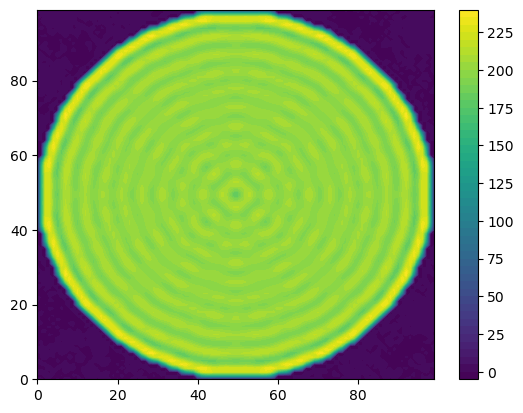

In [11]:
plt.contourf(app(0), levels = 50)
# plt.contourf(U0.reshape([nx, ny]))
plt.colorbar()
plt.show()

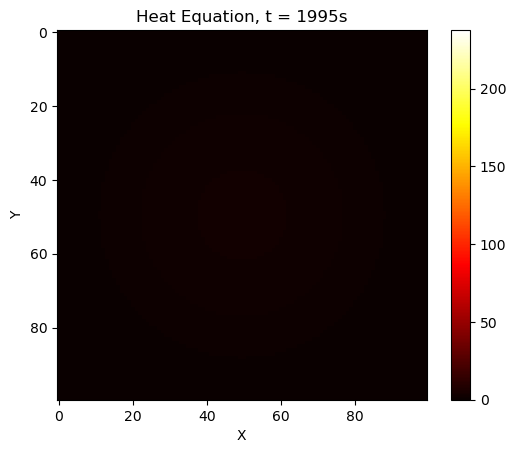

In [12]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
# Initialize the figure and axes
fig, ax = plt.subplots()
im = ax.imshow(app(0), cmap='hot', animated=True)
cbar = fig.colorbar(im)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Heat Equation')

# Define the update function for the animation
s = 5
def update(n):
    im.set_data(app(s*n))
    ax.set_title(f"Heat Equation, t = {s*n}s")
    return im

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=2000//s, interval=50)
ani.save("pictures/My_sol_to_heat_eq.gif",writer='pillow',fps=60)